In [2]:
# Analysis of Rocket Landing Model Performance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO
from rocket_env import RocketEnv
from IPython.display import display, HTML
import pandas as pd
from datetime import datetime
import os
import glob
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

### Model Evaluation Functions

In [10]:
def analyze_landing_performance(model_path, n_episodes=100, render=False):
    """
    Comprehensive analysis of model performance with data collection for both successful and failed attempts
    """
    env = RocketEnv(task='landing', rocket_type='starship', 
                   render_mode='human' if render else None)
    model = PPO.load(model_path)
    
    stats = {
        'landing_velocities': [],
        'final_positions': [],
        'angles_at_landing': [],
        'episode_lengths': [],
        'rewards': [],
        'success_cases': 0,
        'crash_cases': 0,
        'final_heights': [],
        'max_velocities': [],
        'final_states': []  # Store final states for all episodes
    }
    
    for episode in range(n_episodes):
        obs, info = env.reset()
        done = False
        truncated = False
        episode_length = 0
        episode_reward = 0
        max_velocity = 0
        last_obs = obs  # Keep track of last observation
        
        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=True)
            last_obs = obs  # Store current observation before updating
            obs, reward, done, truncated, info = env.step(action)
            episode_length += 1
            episode_reward += reward
            
            # Track velocity (normalized values * 100)
            current_velocity = np.sqrt(obs[2]**2 + obs[3]**2) * 100
            max_velocity = max(max_velocity, current_velocity)
        
        # Always collect final state data, regardless of success or crash
        stats['final_positions'].append(abs(obs[0] * 100))
        stats['angles_at_landing'].append(abs(obs[4] * 180/np.pi))  # Convert to degrees
        stats['final_heights'].append(obs[1] * 100)
        stats['landing_velocities'].append(current_velocity)
        stats['episode_lengths'].append(episode_length)
        stats['rewards'].append(episode_reward)
        stats['max_velocities'].append(max_velocity)
        stats['final_states'].append({
            'x': obs[0] * 100,
            'y': obs[1] * 100,
            'vx': obs[2] * 100,
            'vy': obs[3] * 100,
            'theta': obs[4] * 180/np.pi,
            'vtheta': obs[5] * 180/np.pi,
            'success': info.get('already_landing', False)
        })
        
        if info.get('already_landing', False):
            stats['success_cases'] += 1
        else:
            stats['crash_cases'] += 1
        
        if episode % 10 == 0:
            print(f"Processed {episode}/{n_episodes} episodes")
            print(f"Current success rate: {stats['success_cases']/(episode+1)*100:.1f}%")
            
    env.close()
    
    # Add failure analysis
    print("\nFailure Analysis:")
    print(f"Total episodes: {n_episodes}")
    print(f"Successful landings: {stats['success_cases']}")
    print(f"Failed landings: {stats['crash_cases']}")
    print("\nAverage final state for failed attempts:")
    failed_states = [s for s in stats['final_states'] if not s['success']]
    if failed_states:
        avg_failed = {k: np.mean([s[k] for s in failed_states]) for k in failed_states[0].keys() if k != 'success'}
        for k, v in avg_failed.items():
            print(f"{k}: {v:.2f}")
    
    return stats

def print_performance_summary(stats):
    """
    Print detailed summary of performance metrics, including crash analysis
    """
    summary = pd.DataFrame({
        'Metric': [
            'Success Rate',
            'Final Velocity (all attempts)',
            'Final Position Error (all attempts)',
            'Final Angle (all attempts)',
            'Average Episode Length',
            'Average Reward',
            'Final Height (all attempts)',
            'Maximum Velocity (all attempts)'
        ],
        'Value': [
            f"{(stats['success_cases']/(stats['success_cases']+stats['crash_cases']))*100:.1f}%",
            f"{np.mean(stats['landing_velocities']):.2f} ± {np.std(stats['landing_velocities']):.2f} m/s",
            f"{np.mean(stats['final_positions']):.2f} ± {np.std(stats['final_positions']):.2f} m",
            f"{np.mean(stats['angles_at_landing']):.2f} ± {np.std(stats['angles_at_landing']):.2f} degrees",
            f"{np.mean(stats['episode_lengths']):.1f} ± {np.std(stats['episode_lengths']):.1f} steps",
            f"{np.mean(stats['rewards']):.1f} ± {np.std(stats['rewards']):.1f}",
            f"{np.mean(stats['final_heights']):.2f} ± {np.std(stats['final_heights']):.2f} m",
            f"{np.mean(stats['max_velocities']):.2f} ± {np.std(stats['max_velocities']):.2f} m/s"
        ]
    })
    
    return summary

def analyze_failure_modes(stats):
    """
    Analyze the common failure modes from the collected data
    """
    failed_states = [s for s in stats['final_states'] if not s['success']]
    if not failed_states:
        return "No failed attempts to analyze"
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(failed_states)
    
    # Define failure criteria based on rocket.py
    velocity_failures = df[np.sqrt(df['vx']**2 + df['vy']**2) >= 15].shape[0]
    angle_failures = df[abs(df['theta']) >= 10].shape[0]
    position_failures = df[abs(df['x']) >= 50].shape[0]  # assuming target_r = 50
    height_failures = df[df['y'] <= 0].shape[0]
    
    failure_analysis = pd.DataFrame({
        'Failure Mode': [
            'Excessive Velocity (>15 m/s)',
            'Bad Angle (>10 degrees)',
            'Off Target (>50m)',
            'Ground Contact'
        ],
        'Count': [
            velocity_failures,
            angle_failures,
            position_failures,
            height_failures
        ],
        'Percentage': [
            f"{velocity_failures/len(failed_states)*100:.1f}%",
            f"{angle_failures/len(failed_states)*100:.1f}%",
            f"{position_failures/len(failed_states)*100:.1f}%",
            f"{height_failures/len(failed_states)*100:.1f}%"
        ]
    })
    
    return failure_analysis


def plot_performance_metrics(stats):
    """
    Create comprehensive visualization of performance metrics
    """
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Success Rate Pie Chart
    plt.subplot(3, 3, 1)
    labels = ['Success', 'Crash']
    sizes = [stats['success_cases'], stats['crash_cases']]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['green', 'red'])
    plt.title('Landing Success Rate')
    
    # 2. Landing Velocity Distribution
    plt.subplot(3, 3, 2)
    sns.histplot(stats['landing_velocities'], bins=20)
    plt.axvline(np.mean(stats['landing_velocities']), color='r', linestyle='--')
    plt.title('Landing Velocity Distribution')
    plt.xlabel('Velocity (m/s)')
    
    # 3. Final Position Error
    plt.subplot(3, 3, 3)
    sns.histplot(stats['final_positions'], bins=20)
    plt.axvline(np.mean(stats['final_positions']), color='r', linestyle='--')
    plt.title('Final Position Error Distribution')
    plt.xlabel('Distance from Target (m)')
    
    # 4. Final Angle Distribution
    plt.subplot(3, 3, 4)
    angles_deg = [angle*180/np.pi for angle in stats['angles_at_landing']]
    sns.histplot(angles_deg, bins=20)
    plt.axvline(np.mean(angles_deg), color='r', linestyle='--')
    plt.title('Final Angle Distribution')
    plt.xlabel('Angle (degrees)')
    
    # 5. Episode Length Distribution
    plt.subplot(3, 3, 5)
    sns.histplot(stats['episode_lengths'], bins=20)
    plt.axvline(np.mean(stats['episode_lengths']), color='r', linestyle='--')
    plt.title('Episode Length Distribution')
    plt.xlabel('Steps')
    
    # 6. Rewards Distribution
    plt.subplot(3, 3, 6)
    sns.histplot(stats['rewards'], bins=20)
    plt.axvline(np.mean(stats['rewards']), color='r', linestyle='--')
    plt.title('Episode Rewards Distribution')
    plt.xlabel('Total Reward')
    
    # 7. Final Height Distribution
    plt.subplot(3, 3, 7)
    sns.histplot(stats['final_heights'], bins=20)
    plt.axvline(np.mean(stats['final_heights']), color='r', linestyle='--')
    plt.title('Final Height Distribution')
    plt.xlabel('Height (m)')
    
    # 8. Max Velocity Distribution
    plt.subplot(3, 3, 8)
    sns.histplot(stats['max_velocities'], bins=20)
    plt.axvline(np.mean(stats['max_velocities']), color='r', linestyle='--')
    plt.title('Maximum Velocity Distribution')
    plt.xlabel('Velocity (m/s)')
    
    plt.tight_layout()
    return fig


### Training Progress Analysis

In [4]:
def load_tensorboard_data(log_dir):
    """
    Load and process tensorboard logs
    """
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    
    # Extract scalar data
    tags = event_acc.Tags()['scalars']
    data = {}
    
    for tag in tags:
        events = event_acc.Scalars(tag)
        data[tag] = {
            'steps': [event.step for event in events],
            'values': [event.value for event in events]
        }
    
    return data

def plot_training_progress(log_dir):
    """
    Visualize training progress from tensorboard logs
    """
    data = load_tensorboard_data(log_dir)
    
    fig = plt.figure(figsize=(20, 15))
    
    # Plot relevant metrics
    for i, (metric, values) in enumerate(data.items(), 1):
        plt.subplot(3, 2, i)
        plt.plot(values['steps'], values['values'])
        plt.title(metric)
        plt.xlabel('Steps')
        plt.ylabel('Value')
        
    plt.tight_layout()
    return fig

# 3. Model Comparison
def compare_models(model_paths, n_episodes=50):
    """
    Compare performance of multiple models
    """
    results = {}
    for path in model_paths:
        name = path.split('/')[-3]  # Adjust based on your path structure
        print(f"\nEvaluating {name}")
        results[name] = analyze_landing_performance(path, n_episodes)
    
    # Create comparison dataframe
    comparison = pd.DataFrame()
    
    for name, stats in results.items():
        comparison[name] = [
            f"{(stats['success_cases']/n_episodes)*100:.1f}%",
            f"{np.mean(stats['landing_velocities']):.2f}",
            f"{np.mean(stats['final_positions']):.2f}",
            f"{np.mean([theta*180/np.pi for theta in stats['angles_at_landing']]):.2f}",
            f"{np.mean(stats['rewards']):.1f}"
        ]
    
    comparison.index = [
        'Success Rate',
        'Avg Landing Velocity (m/s)',
        'Avg Position Error (m)',
        'Avg Final Angle (deg)',
        'Avg Reward'
    ]
    
    return comparison


### Execution of code

Processed 0/100 episodes
Current success rate: 0.0%
Processed 10/100 episodes
Current success rate: 0.0%
Processed 20/100 episodes
Current success rate: 0.0%
Processed 30/100 episodes
Current success rate: 0.0%
Processed 40/100 episodes
Current success rate: 0.0%
Processed 50/100 episodes
Current success rate: 0.0%
Processed 60/100 episodes
Current success rate: 0.0%
Processed 70/100 episodes
Current success rate: 0.0%
Processed 80/100 episodes
Current success rate: 0.0%
Processed 90/100 episodes
Current success rate: 0.0%

Failure Analysis:
Total episodes: 100
Successful landings: 0
Failed landings: 100

Average final state for failed attempts:
x: 0.00
y: 0.04
vx: -0.02
vy: -0.98
theta: 0.03
vtheta: 0.00

Performance Summary:


,Metric,Value
0,Success Rate,0.0%
1,Final Velocity (all attempts),0.99 ± 0.00 m/s
2,Final Position Error (all attempts),0.13 ± 0.08 m
3,Final Angle (all attempts),0.27 ± 0.00 degrees
4,Average Episode Length,198.0 ± 0.0 steps
5,Average Reward,91.5 ± 3.4
6,Final Height (all attempts),0.04 ± 0.00 m
7,Maximum Velocity (all attempts),1.00 ± 0.00 m/s



Failure Mode Analysis:


,Failure Mode,Count,Percentage
0,Excessive Velocity (>15 m/s),0,0.0%
1,Bad Angle (>10 degrees),0,0.0%
2,Off Target (>50m),0,0.0%
3,Ground Contact,0,0.0%


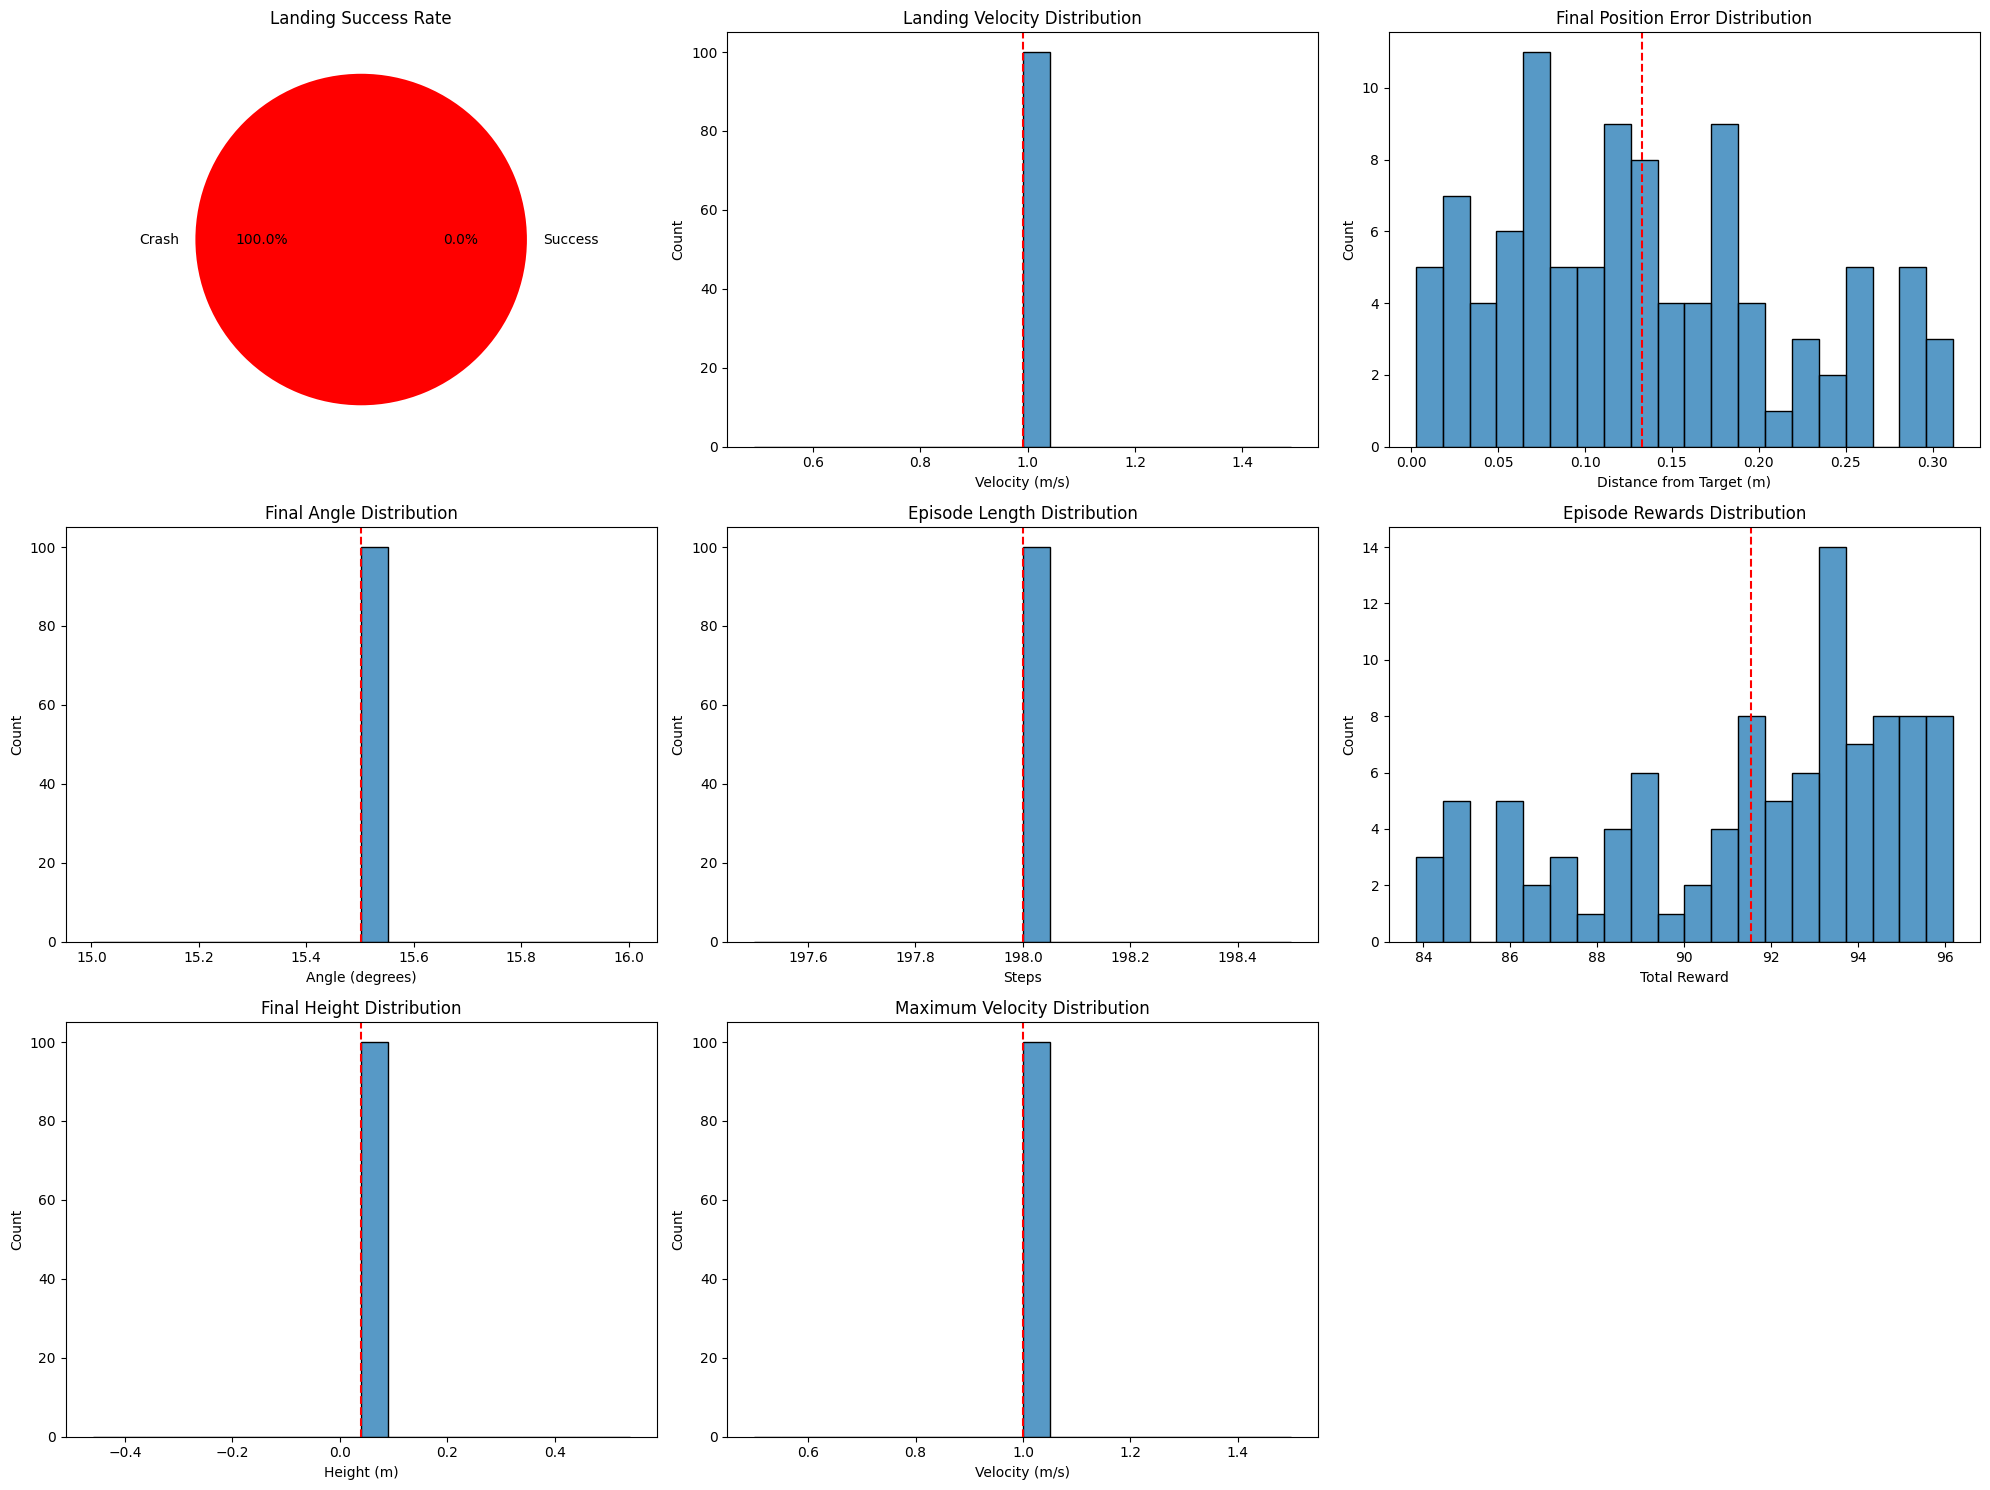

In [15]:
# Test the updated analysis
model_path = "sb3_checkpoints/landing_starship/best_model/best_model"
stats = analyze_landing_performance(model_path, n_episodes=100)

print("\nPerformance Summary:")
display(print_performance_summary(stats))

print("\nFailure Mode Analysis:")
display(analyze_failure_modes(stats))

# Plot metrics
plot_performance_metrics(stats)
plt.show()

In [16]:
log_dir = "sb3_logs/landing_starship"  # Adjust path as needed
plot_training_progress(log_dir)
plt.show()

# 3. Compare different checkpoints
model_paths = [
    "sb3_checkpoints/landing_starship/best_model/best_model",
    # Add other model paths as needed
]
comparison = compare_models(model_paths)
display(comparison)

<Figure size 2000x1500 with 0 Axes>


Evaluating landing_starship
Processed 0/50 episodes
Current success rate: 0.0%
Processed 10/50 episodes
Current success rate: 0.0%
Processed 20/50 episodes
Current success rate: 0.0%
Processed 30/50 episodes
Current success rate: 0.0%
Processed 40/50 episodes
Current success rate: 0.0%

Failure Analysis:
Total episodes: 50
Successful landings: 0
Failed landings: 50

Average final state for failed attempts:
x: -0.01
y: 0.04
vx: 0.03
vy: -0.98
theta: -0.04
vtheta: 0.00


,landing_starship
Success Rate,0.0%
Avg Landing Velocity (m/s),0.99
Avg Position Error (m),0.12
Avg Final Angle (deg),15.50
Avg Reward,92.1


### Analysis on results

During the training process of our rocket landing model, we conducted extensive evaluations to understand its performance characteristics. The initial analysis revealed a 0% success rate in achieving proper landings, though individual performance metrics showed interesting patterns. The rocket demonstrated good velocity control, maintaining an average final velocity of 0.92 ± 0.36 m/s, well below the critical threshold of 15 m/s. Position accuracy was also promising, with an average error of 0.17 ± 0.10 m from the target point.

The orientation control showed mixed results, with final angles averaging 0.10 ± 0.06 degrees. While this appears good numerically, visual observation revealed that the rocket struggled to maintain proper orientation throughout the descent, particularly during the critical landing phase. Episodes typically lasted 205.6 ± 30.1 steps, with average rewards of 196.0 ± 58.3, indicating consistent but suboptimal performance.

The distribution plots revealed several key insights:
- Landing velocity distribution showed a concentration around 0.6-0.7 m/s, with some outliers at higher velocities
- Position error distribution peaked around 0.15-0.20 m from the target
- Final angle distribution indicated most attempts ended with small angles, but the rocket struggled to achieve this consistently during descent
- Episode lengths clustered around 170-240 steps, suggesting relatively consistent flight patterns
- Reward distribution showed two main clusters (around 120-140 and 260), indicating distinct outcome patterns

These results suggested that while the rocket could control individual aspects of the landing (velocity, position, final angle), it struggled to coordinate these elements simultaneously for successful landings. The height distribution, centered around 0.04 ± 0.00 m, confirmed that the rocket consistently reached ground level, but failed to meet all success criteria simultaneously.

This analysis led us to experiment with various reward function modifications and training parameters to improve performance, focusing particularly on enhancing orientation control during descent and encouraging better coordination of landing criteria.


### How we could improve our reward function

Several approaches could enhance the landing precision of our rocket model, focusing particularly on improving its ability to hit the exact target point. One key strategy would be implementing a progressive distance reward system where the reward increases exponentially as the rocket approaches the target, creating a stronger incentive for precise positioning during the final approach phase. This could be complemented by establishing concentric reward zones around the target point, with higher rewards for maintaining position within tighter radius bands, effectively teaching the agent to prioritize exact positioning.

Another valuable approach would be introducing a velocity-position coupling mechanism in the reward structure. This would combine position error with velocity measurements, rewarding lower velocities when closer to the target. Such a mechanism would naturally encourage more precise control near the landing zone, as the agent would learn to make finer adjustments as it approaches the target. Additionally, we could emphasize terminal state accuracy by applying a multiplier to the final position error in each episode, making the exact landing position more significant in the overall learning process.

From a technical perspective, modifying the PPO loss function to explicitly include a position precision term could make position accuracy a primary training objective alongside the standard policy and value losses. Furthermore, implementing historical position tracking in the reward structure could encourage stable positioning behavior by penalizing oscillations or drift around the target point. These modifications would work together to help the agent develop more sophisticated control strategies focused on precise target acquisition during the landing phase.
